In [1]:
from kafka import KafkaConsumer
from json import loads
import json
from pymongo import MongoClient
import time
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import tensorflow as tf
from pyspark.sql.functions import sum as spark_sum
import matplotlib.pyplot as plt

In [2]:
clt=MongoClient("mongodb://localhost:27017/")
db = clt["ex7"]
collection = db["ex1_cl"]

In [3]:
# Set up Kafka consumer
con = KafkaConsumer("yt7",
                   bootstrap_servers=["localhost:9092"],
                   api_version=(0, 10, 1))

# Listen for messages for the specified duration
while True:
    messages = con.poll(timeout_ms=70000)  # Timeout in milliseconds

    if len(messages) == 0:
        break

    for message in messages.values():
        for msg in message:
            data = msg.value.decode('utf-8')
            print(data)
            collection.insert_one({"data": data})

# Stop the Kafka consumer
con.close()

{"video_id": "-WNsfHQduxc", "video_title": "$1,000 Half Dollar HUNT! Coin Roll Hunting for Silver Coins", "duration": 69.33333333333333, "views": "2236", "likes": "112", "category": "Film & Animation", "published_time": "2023-11-18T13:19:20Z"}
{"video_id": "CMKgG9TWauc", "video_title": "\u3010 \u8e0f\u5207\u30a2\u30cb\u30e1 \u3011 LIVE #629 \u8e0f\u5207\u30ab\u30f3\u30ab\u30f3 \u3075\u307f\u304d\u308a railroad crossing", "duration": 229.3, "views": "3117", "likes": "15", "category": "Film & Animation", "published_time": "2023-11-18T12:54:43Z"}
{"video_id": "PbkRo5m3RE8", "video_title": "\u00bfCharlamos un rato en Directo? - 18/11/2023", "duration": 76.13333333333334, "views": "686", "likes": "72", "category": "Film & Animation", "published_time": "2023-11-18T13:19:46Z"}
{"video_id": "GnhlUG44f3s", "video_title": "\u092a\u093e\u091a\u094b \u092a\u093e\u0902\u0921\u0935\u094b \u092e\u0947\u0902 \u0926\u094d\u0930\u094c\u092a\u0926\u0940 \u0915\u0948\u0938\u0947 \u092c\u091f\u0940,\u0905\

In [4]:
spark = SparkSession.builder.appName("rgb").getOrCreate()
spark

In [5]:
# Create the DataFrame
data = list(collection.find())
df = pd.DataFrame(data)
lt=df["data"]
schema = StructType([
    StructField("video_id", StringType(), nullable=True),
    StructField("video_title", StringType(), nullable=True),
    StructField("duration", StringType(), nullable=True),
    StructField("views", StringType(), nullable=True),
    StructField("likes", StringType(), nullable=True),
    StructField("category", StringType(), nullable=True),
    StructField("published_time", StringType(), nullable=True)
])

df = spark.createDataFrame(lt, StringType()) \
    .select(from_json("value", schema).alias("data")) \
    .select("data.*")
df.show()

+-----------+---------------------------------+------------------+-----+-----+----------------+--------------------+
|   video_id|                      video_title|          duration|views|likes|        category|      published_time|
+-----------+---------------------------------+------------------+-----+-----+----------------+--------------------+
|7Zk2SGQNRCs|             PJ Masks | Season...| 479.3333333333333| 6080|   48|Film & Animation|2023-11-15T14:58:14Z|
|vzJYnRcNYzA|             Here Come The PJ ...|179.18333333333334| 1670|   10|Film & Animation|2023-11-15T14:40:58Z|
|ovkwVZ2JzB0|[바카라 실시간]모든키워드 노필...|              84.8| 5103|    0|Film & Animation|2023-11-15T15:00:31Z|
|xmj3uCw_mNw|             PJ Masks get turn...|             179.3|  727|    2|Film & Animation|2023-11-15T14:42:09Z|
|tFEFklrGAjM|             Motu Raju Patlu K...|53.833333333333336|  275|    2|Film & Animation|2023-11-15T14:46:49Z|
|ncDuYSk1Jnc|             Victory Apostolic...| 72.18333333333334|  258|    7

In [6]:
# Get the number of rows
num_rows = df.count()
num_rows

7987

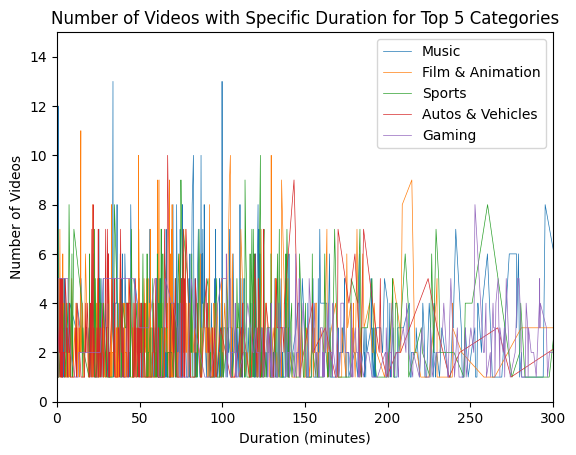

In [7]:
df = df.withColumn("duration", col("duration").cast("float"))

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.toPandas()

# Group by category and duration, and count the number of videos
grouped_df = pandas_df.groupby(['category', 'duration']).size().reset_index(name='count')

# Get the top 5 categories with the most videos
top_categories = grouped_df['category'].value_counts().head(5).index.tolist()

# Filter the DataFrame for the top 5 categories
filtered_df = grouped_df[grouped_df['category'].isin(top_categories)]

# Plot all lines in a single plot
fig, ax = plt.subplots()

for category in top_categories:
    category_data = filtered_df[filtered_df['category'] == category]
    ax.plot(category_data['duration'], category_data['count'], linestyle='-', linewidth=0.5, label=category)

ax.set_xlim(0,300)
ax.set_ylim(0,15)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Number of Videos')
ax.set_title('Number of Videos with Specific Duration for Top 5 Categories')

ax.legend()
plt.show()

+----------------+-----------+
|        category|total_likes|
+----------------+-----------+
|          Gaming|   404658.0|
| Travel & Events|    14301.0|
|          Sports|   293219.0|
|Film & Animation|    78819.0|
|  People & Blogs|   283448.0|
|  Pets & Animals|    49642.0|
|Autos & Vehicles|    28254.0|
|           Music|   322900.0|
|   Entertainment|    22595.0|
|          Comedy|      962.0|
+----------------+-----------+



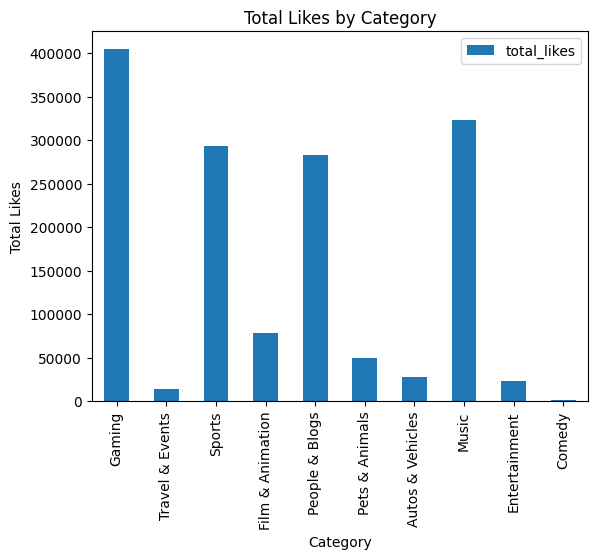

In [8]:
category_likes = df.groupBy('category').agg(spark_sum('likes').alias('total_likes'))
category_likes.show()
category_likes_pd=category_likes.toPandas()
ax = category_likes_pd.plot(kind='bar', x='category', y='total_likes')
ax.set_xlabel('Category')
ax.set_ylabel('Total Likes')
ax.set_title('Total Likes by Category')
plt.show()

+----------------+-----------+
|        category|total_views|
+----------------+-----------+
|          Gaming|1.5685554E7|
| Travel & Events|   393390.0|
|          Sports|1.9364249E7|
|Film & Animation|  2555981.0|
|  People & Blogs|  2988548.0|
|  Pets & Animals|  1264332.0|
|Autos & Vehicles|   596504.0|
|           Music|2.5959309E7|
|   Entertainment|   596617.0|
|          Comedy|    27223.0|
+----------------+-----------+



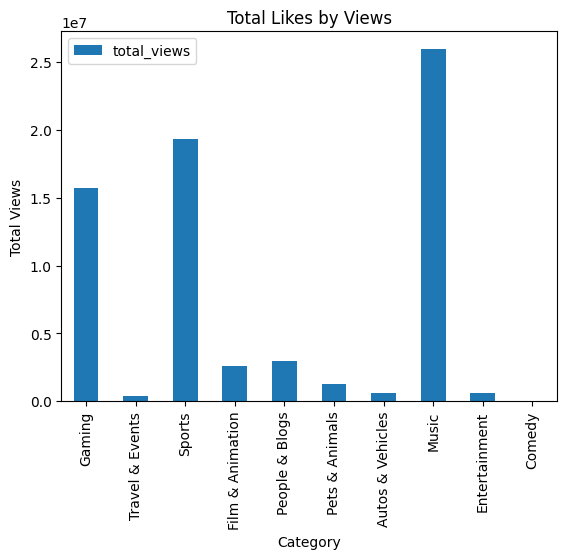

In [9]:
category_views = df.groupBy('category').agg(spark_sum('views').alias('total_views'))
category_views.show()
category_views_pd=category_views.toPandas()
ax=category_views_pd.plot(kind='bar', x='category', y='total_views')
ax.set_xlabel('Category')
ax.set_ylabel('Total Views')
ax.set_title('Total Likes by Views')
plt.show()

+----------------+----------------+
|        category|number of videos|
+----------------+----------------+
|          Gaming|             710|
| Travel & Events|             417|
|          Sports|            1117|
|Film & Animation|            1600|
|  People & Blogs|             597|
|  Pets & Animals|             576|
|Autos & Vehicles|             779|
|           Music|            2087|
|   Entertainment|              74|
|          Comedy|              30|
+----------------+----------------+



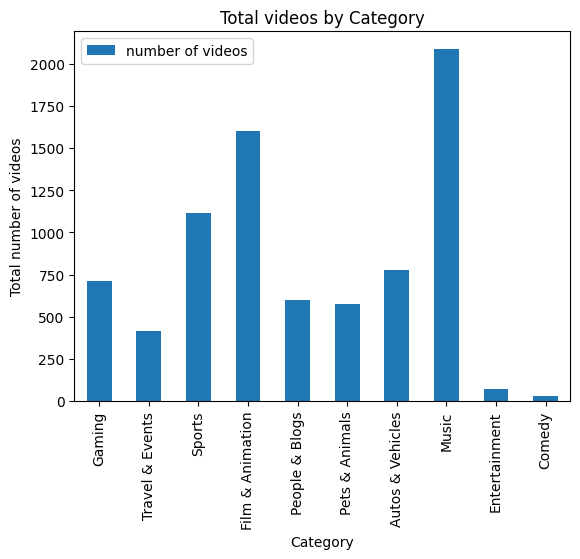

In [10]:
category_counts = df.groupBy('category').agg(F.count('*').alias('number of videos'))
category_counts.show()
category_counts_pd = category_counts.toPandas()
ax=category_counts_pd.plot(kind='bar', x='category', y='number of videos')
ax.set_xlabel('Category')
ax.set_ylabel('Total number of videos')
ax.set_title('Total videos by Category')
plt.show()

+----------------+-------------------+
|        category|duration in minutes|
+----------------+-------------------+
|          Gaming| 140040.69984060526|
| Travel & Events|  49200.84973210096|
|          Sports| 130363.83353227377|
|Film & Animation| 194321.60041034222|
|  People & Blogs|  78444.14999368414|
|  Pets & Animals| 125357.36724043638|
|Autos & Vehicles|  82610.68326859176|
|           Music| 460558.30202683434|
|   Entertainment|  9519.733398534358|
|          Comedy|  2179.166676044464|
+----------------+-------------------+



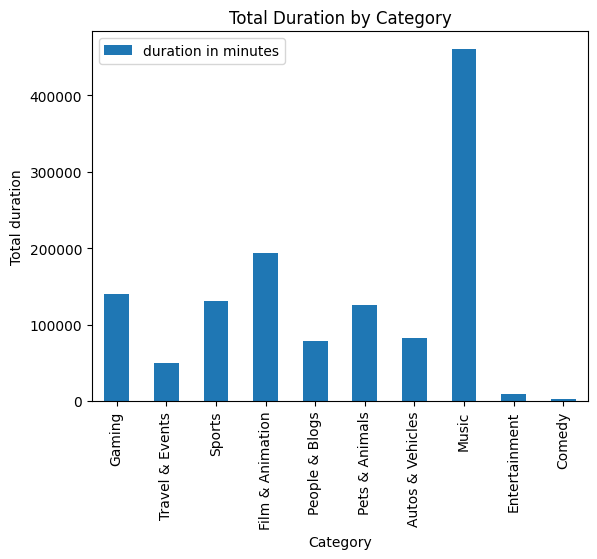

In [11]:
category_duration = df.groupBy('category').agg(spark_sum('duration').alias('duration in minutes'))
category_duration_pd=category_duration.toPandas()
category_duration.show()
ax=category_duration_pd.plot(kind='bar', x='category', y='duration in minutes')
ax.set_xlabel('Category')
ax.set_ylabel('Total duration')
ax.set_title('Total Duration by Category')
plt.show()

In [12]:
spark.stop()